## Summary

To better understand the effect of predictors of remittance prices I used a RuleFit model. This model fits trees to construct variables on which to regress: these are like [rules](#seerules); in this way one can capture both linear effects and interactions among variables. Also, one can evaluate results using $l^1$-loss: $E(|pred-trueval|)$ which is less sensitive to noise than the quadratic loss used in the command lm.

To evaluate the results I split the data in Train & Test on time because we want to forecast the future. Train consists of the first 75% days in the data. As a [benchmark](#bench) I used an estimate, on Test, which assigns the corridor-mean: the loss is about 2.83. RuleFit achieves a [loss](#ruleloss) of about 1.21, so a 57% improvement.

[Here](#impplot) are an importance plot and ranking of the variables. This measures both the number of times a variable is used in a rule and how big the coefficients of rules in which it appears are. Findings are consistent with the exploratory analysis: note that corridor overshadows the other regional variables which appear insignificant to the model.

I then looked at the effect of [time](#timeplot) which has a linear negative effect. I then looked at the effect of [firm_type](#bankplot): Bank makes transfers more expensive than other types.

The model is non-linear, I looked at [how strongly each variable interacted with the others](#intplot) and how
[strongly corridor interacted with the others](#intcorr). Finally I looked at the [interaction of firm_type and time](#firmtime): the downward trend is similar, but say for Banks a bit stronger than Money Transfer. Note also that for Credit Union we have observations in a more limited time range.

Finally I reported the [6 most significant rules](#seerules) and also the top rule (#34) with a 3-way interaction. The model is first using some linear effects, but then also rules based on interactions with variables. 

With more time I would look at the interaction of firm_type and corridors.

In [2]:
require(ggplot2)
require(dplyr)
# Load RuleFit saved in another directory
RFHOME <- '~/leave_academia/palombo-book/'
rfhome <- RFHOME
platform = 'mac'
source(paste0(RFHOME,"/rulefit.r"))
library(akima, lib.loc = RFHOME)

Loading required package: ggplot2
Warning message:
: package 'ggplot2' was built under R version 3.2.4Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [3]:
# read and process the data
dfAll <- read.csv('dfAll.csv', header = T, stringsAsFactors = F) # Could not work on this in one time-block
names(dfAll)[which(names(dfAll) == 'cc1.total.cost..')] <- 'cc1'
names(dfAll)[which(names(dfAll) == 'cc2.total.cost..')] <- 'cc2'
cc <- unique(dfAll$date)
MinDate <- min(cc)
ddiff <- difftime(as.Date(cc), as.Date(MinDate), units='days')
DateMask <- data.frame(date = cc, time = as.numeric(ddiff))
dfAll <- dfAll %>% merge(DateMask, by='date')

In [4]:
# numerical and factor predictors
numVars <- c('cc1', 'cc1.lcu.amount', 'cc1.lcu.fee',
                  'cc1.lcu.fx.rate' ,'cc1.fx.margin','inter.lcu.bank.fx','time','weekno')
factorNames <- c('source_code', 'source_name' ,'source_region', 'source_income' ,'source_lending',
                 'source_G8G20' ,'destination_code' ,'destination_name' ,'destination_region', 'destination_income',
                 'destination_lending' ,'destination_G8G20','firm_type' ,'product', 'sending.location' ,
                 'speed.actual','transparent',  'receiving.network.coverage', 'receiving.method' ,'corridor',
                 'payment.instrument', 'sending.network.coverage', 'cash.pickup.location','weekday')

In [5]:
# convert character to factors
dfRule <- dfAll[, c(numVars, factorNames)]
for(i in 1:length(factorNames)) {
    dfRule[, factorNames[i]] <- factor(dfRule[, factorNames[i]])
}

In [6]:
summary(dfRule)

      cc1         cc1.lcu.amount    cc1.lcu.fee     cc1.lcu.fx.rate   
 Min.   :-8.970   Min.   :    65   Min.   :     0   Min.   :    0.00  
 1st Qu.: 4.110   1st Qu.:   140   1st Qu.:     6   1st Qu.:    1.00  
 Median : 6.620   Median :   200   Median :    10   Median :    3.88  
 Mean   : 8.335   Mean   :  9202   Mean   :   983   Mean   :  387.59  
 3rd Qu.:10.710   3rd Qu.:   260   3rd Qu.:    25   3rd Qu.:   46.39  
 Max.   :75.000   Max.   :324500   Max.   :146025   Max.   :32027.46  
                  NA's   :103      NA's   :6                          
 cc1.fx.margin     inter.lcu.bank.fx       time          weekno     
 Min.   :-16.580   Min.   :    0.00   Min.   :   0   Min.   : 3.00  
 1st Qu.:  0.000   1st Qu.:    1.00   1st Qu.: 750   1st Qu.: 7.00  
 Median :  1.210   Median :    4.01   Median :1209   Median :19.00  
 Mean   :  1.785   Mean   :  396.69   Mean   :1150   Mean   :22.53  
 3rd Qu.:  2.780   3rd Qu.:   47.53   3rd Qu.:1677   3rd Qu.:36.00  
 Max.   : 36.050  

In [7]:
# We split Train - Test on time @ 3rd quantile
# Train <- time <= 1677 
# Test <- time > 1677 
dfTrain <- dfRule %>% filter(time <= 1677)
dfTest <- dfRule %>% filter(time > 1677)

<a id='bench'></a>

In [8]:
# Create a BenchMark as average per corridor (on the Test!!)
# So we want to beat a model that can look into the future
# Use L1-loss: more robust with noise
dfBench <- dfTest %>% group_by(corridor) %>% mutate(mcc1 = mean(cc1,na.rm=T))
mean(abs(dfBench$cc1-dfBench$mcc1))

[1] 2.826185

In [9]:
Sys.time() -> tme
set.seed(321)
myRule <- rulefit(x = dfTrain[,-1], y = dfTrain[, 1], rfmode = 'regress', model.type="both",
                 mod.sel = 1, tree.size = 4) #absolute error loss
Sys.time()-tme

Time difference of 28.87794 secs

<a id='ruleloss'></a>

In [10]:
myPred <- rfpred(dfTest[,-c(1)])
mean(abs(myPred-dfTest$cc1))

[1] 1.208329

We improve on the benchmark by 57%:

In [12]:
(2.8262-1.2083)/2.8262

[1] 0.5724648

Let's look at variable importance

<a id='impplot'></a>

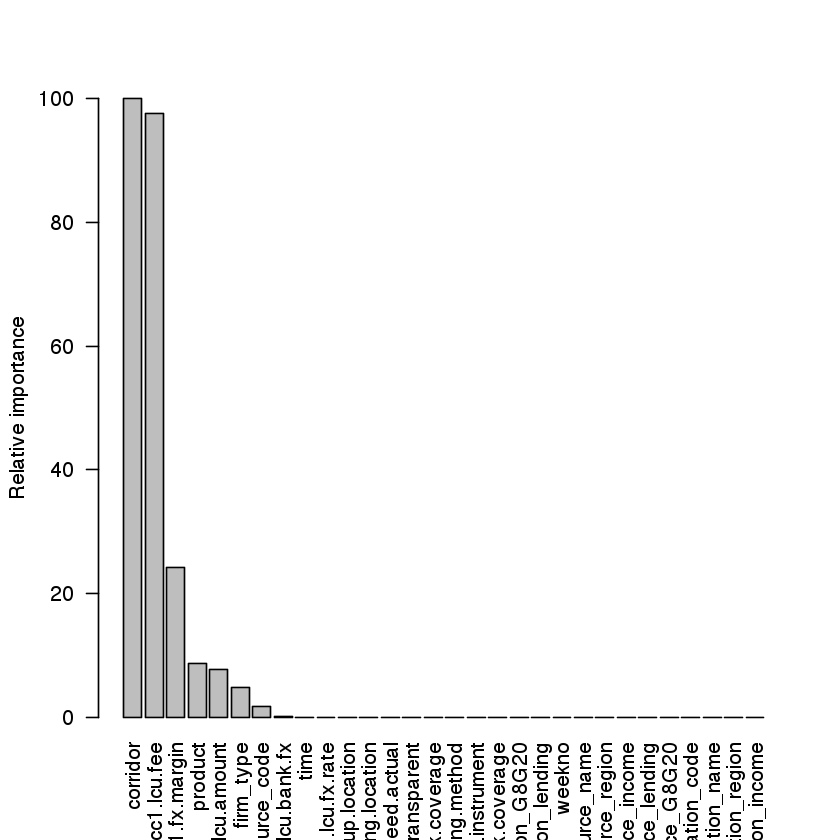

In [13]:
myImp <- varimp()

In [14]:
data.frame(Name = names(dfTrain[,-c(1)])[myImp$ord], Imp = myImp$imp) # variable importance 

,Name,Imp
1,corridor,100
2,cc1.lcu.fee,97.5995710628199
3,cc1.fx.margin,24.1833951674645
4,product,8.65727301607813
5,cc1.lcu.amount,7.82593789095159
6,firm_type,4.88314347600911
7,source_code,1.87259886280776
8,inter.lcu.bank.fx,0.144345793249798
9,time,0.0912727472538921
10,cc1.lcu.fx.rate,0.00281177697009765


This is not surprising; note things like sending.location were important in the previous analysis but here are superseded by corridor: the model just split on corridor which has more information.

The time effect is linear and captures the downward trend

<a id='timeplot'></a>

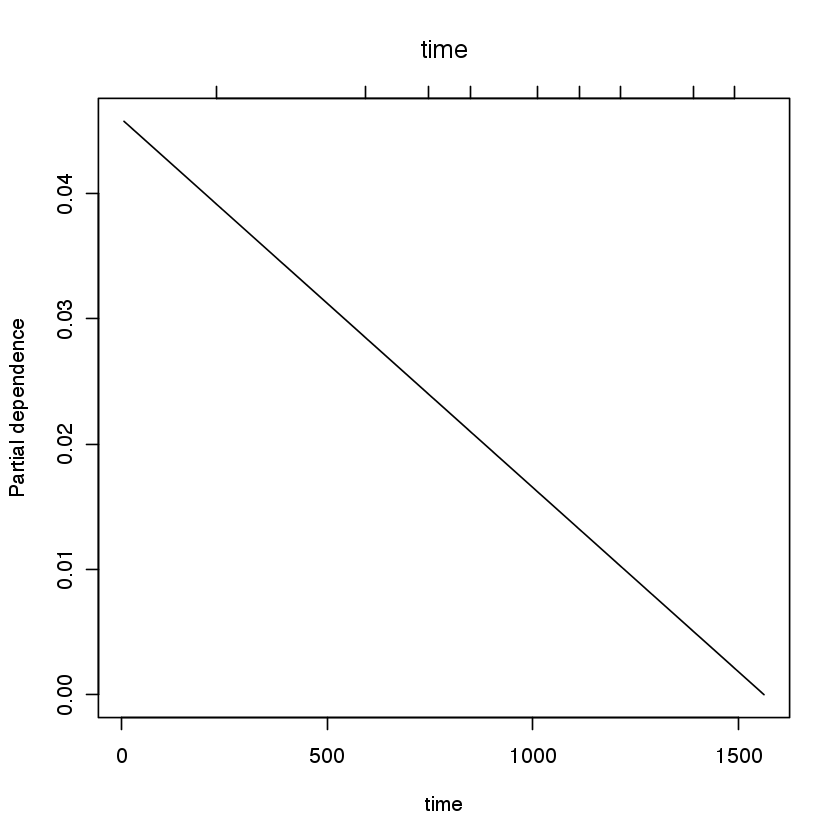

In [15]:
singleplot('time')

Some firms are more convenient than others. Banks perform worse

<a id='bankplot'></a>

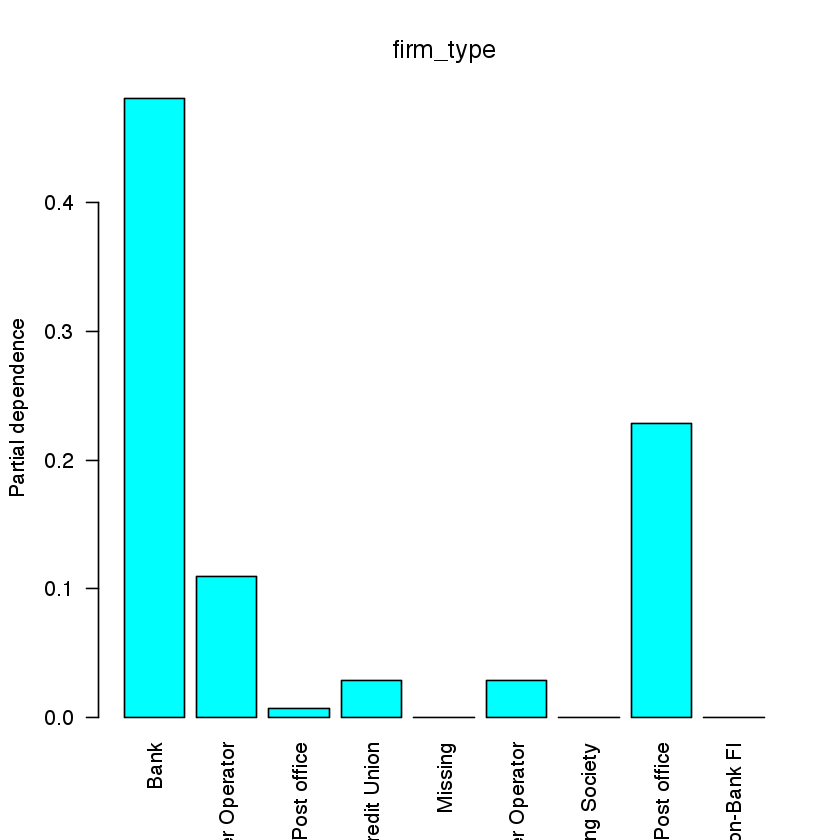

In [16]:
singleplot('firm_type', catvals = levels(dfTrain$firm_type))

Strength of interactions

<a id='intplot'></a>

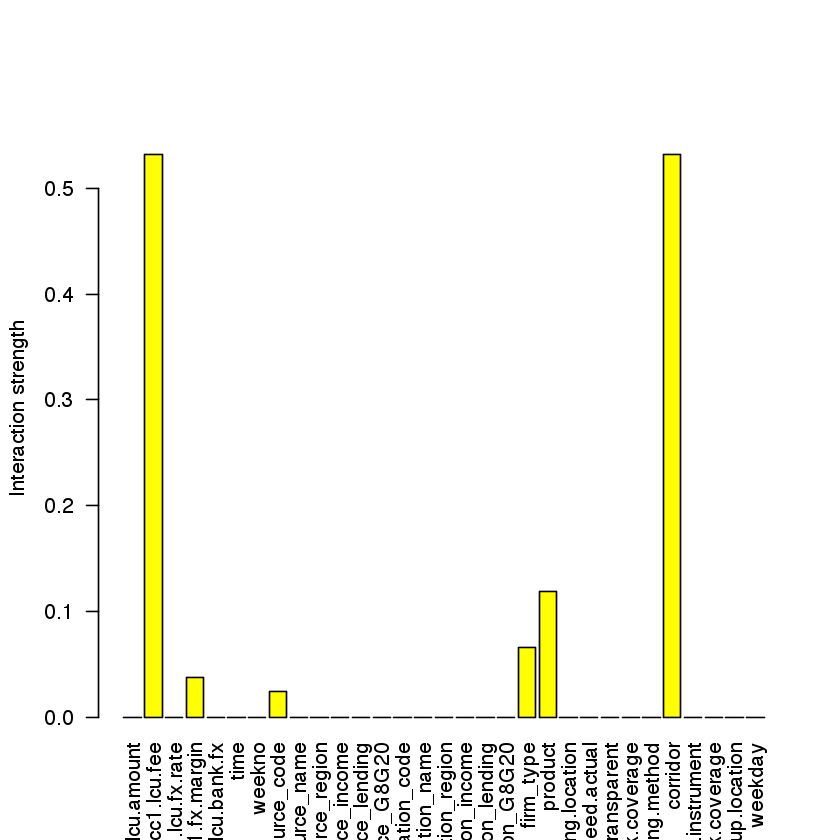

In [17]:
interact(names(dfTrain)[-1])

<a id='seerules'></a>

In [20]:
rules(beg=30,end=40)

Rule   1:   linear cc1.lcu.fee
     std =   1318.     coeff =  0.2043E-02       impotance =   100.0    

Rule   2:   linear cc1.fx.margin
     std =   1.983     coeff =  0.9956           impotance =   73.33    

Rule   3:   linear cc1.lcu.amount
     std =  0.3913E+05 coeff = -0.2919E-04       impotance =   42.42    

Rule   4:     1  variables
     support =  0.8998      coeff =   2.489      importance =   27.76    
     cc1.lcu.fee:  range =   1.750       3438.    

Rule   5:     2  variables
     support =  0.7110E-01  coeff =   1.949      importance =   18.60    
     cc1.lcu.fee:  range =   30.84      0.9900E+36
     product  in:
        33.00       10.00       1.000       37.00       27.00         

Rule   6:     2  variables
     support =  0.2725E-02  coeff =   9.321      importance =   18.04    
     cc1.lcu.fee:  range =   291.0       3750.    
     corridor  not in:
        190.0       193.0       194.0       236.0       201.0            243.0       18.00       31.00    
     corridor  not in:
        368.0       97.00       89.00       87.00       81.00            318.0       93.00       53.00       84.00       69.00            94.00       142.0       163.0       36.00       79.00            348.0       22.00       135.0       88.00       80.00            137.0       64.00       319.0       127.0       327.0            129.0    

Rule  34:     3  variables
     support =  0.4645E-03  coeff =   7.677      importance =   6.143    
     cc1.lcu.fee:  range =   27.35      0.9900E+36
     product  in:
        2.000       37.00       25.00       24.00       1.000            9.000       21.00       36.00       14.00    
     corridor  in:
        163.0       227.0  

<a id='intcorr'></a>

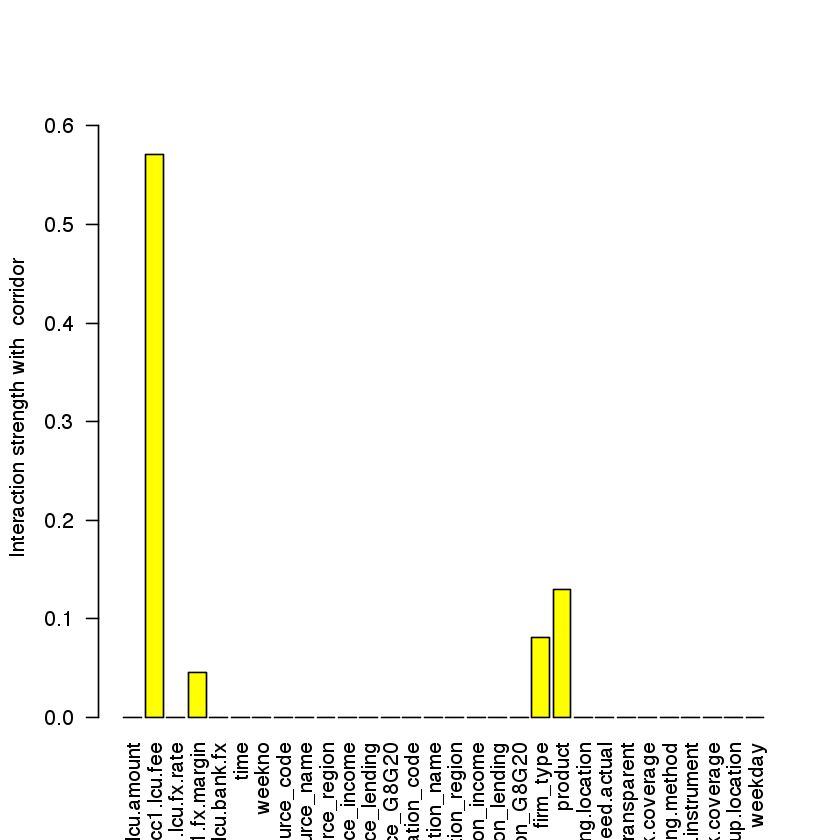

In [21]:
twovarint('corridor', setdiff(names(dfTrain),c('corridor','cc1')))

<a id='firmtime'></a>

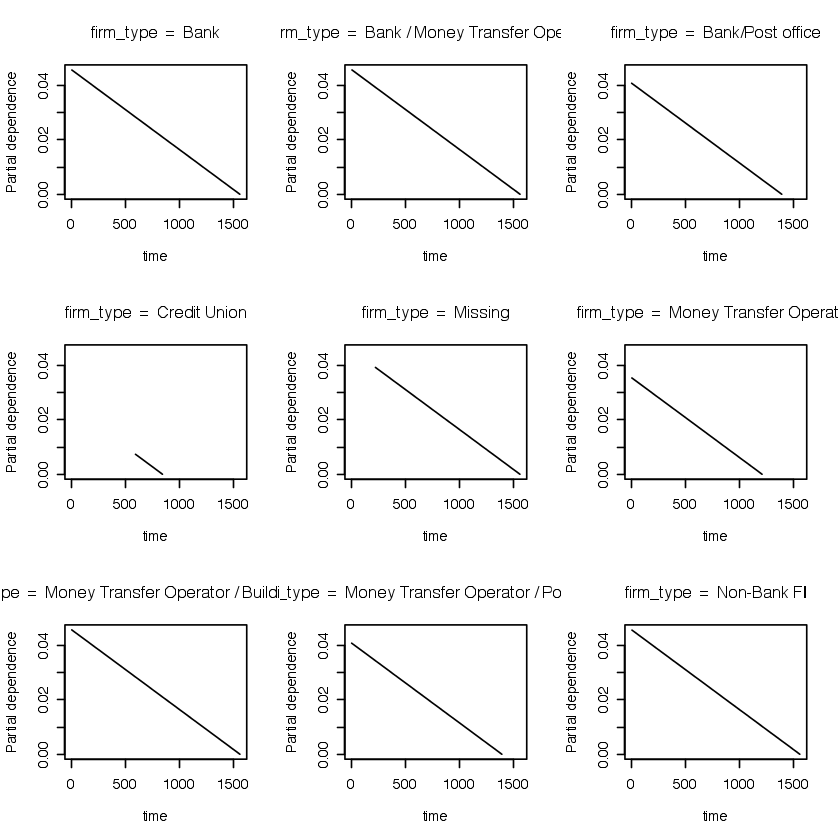

In [22]:
pairplot('firm_type', 'time', vals1=levels(dfTrain$firm_type))